# Amazon Reviews

[Readme](https://s3.amazonaws.com/amazon-reviews-pds/readme.html) \
[Index](https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt)


## Column Descriptions

* marketplace       - 2 letter country code of the marketplace where the review was written.
* customer_id       - Random identifier that can be used to aggregate reviews written by a single author.
* review_id         - The unique ID of the review.
* product_id        - The unique Product ID the review pertains to. In the multilingual dataset the reviews for the same product in different countries can be grouped by the same product_id.
* product_parent    - Random identifier that can be used to aggregate reviews for the same product.
* product_title     - Title of the product.
* product_category  - Broad product category that can be used to group reviews (also used to group the dataset into coherent parts).
* star_rating       - The 1-5 star rating of the review.
* helpful_votes     - Number of helpful votes.
* total_votes       - Number of total votes the review received.
* vine              - Review was written as part of the Vine program.
* verified_purchase - The review is on a verified purchase.
* review_headline   - The title of the review.
* review_body       - The review text.
* review_date       - The date the review was written.


In [2]:
import pandas as pd
import gzip
import os

from typing import Dict, Optional, List, Union

### Download, Parse and Load Dataset

In [5]:
def parse_gz(path: str):
    '''
    Open GZ file and decode bytes to strings
    inputs:
        path: string, path to the .gz file
    '''
    g = gzip.open(path, 'rb')
    for l in g:
        l = l.decode("utf-8") 
        yield l
        
def read_reviews(path: str):
    '''
    Read Amazon's product reviews file and return a pandas DataFrame
    inputs:
        path: string, path to the .tsv.gz file
    '''
    data = []
    for i, line in enumerate(parse_gz(path)):
        
        line = line.split('\t') # separate the tab separated line
        line[-1] = line[-1].strip() # remove trailing new lines
        data.append(line)
        
    columns = data.pop(0)
    return pd.DataFrame.from_records(data, columns=columns)

def download_reviews(url: str, location: str, filename: Optional[str] = 'reviews.gz'):
    '''
    
    '''
    
    # create new directory to store the product reviews
    try:
        os.makedirs(location)
        print('Successfully created new directory')
    except FileExistsError:
        print(f'Directory already exists')
    
    print('Starting to download the dataset')
    path = os.path.join(location, filename) # create the full path to store the download
    urllib.request.urlretrieve(url, path) 
    print('Download completed')
    
    print('Parsing and converting the GZip file as a pandas DataFrame. This may take awhile...')
    df = read_reviews(path)
    print('Successfully created a new DataFrame containing Amazon product reviews')
    
    save_csv = input('Would you like to save this DataFrame as a CSV to avoid having to parse the file again? Type yes proceed\n')
    
    if save_csv.lower() == 'yes':
        save_as = input('How would you like to name the DataFrame?\n')
        path = f'{location}/{save_as}'
        df.to_csv(path, index=False)
        print(f'Successfully saved {path}')
    
    return df, path

In [6]:
%%time

url = 'https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Electronics_v1_00.tsv.gz'
location = 'reviews/raw'
filename = 'reviews.gz'

# download the reviews
_, csv_location = download_reviews(url, location, filename)

Directory already exists
Starting to download the dataset
Download completed
Parsing and converting the GZip file as a pandas DataFrame. This may take awhile...
Successfully created a new DataFrame containing Amazon product reviews
Would you like to save this DataFrame as a CSV to avoid having to parse the file again? Type yes proceed
yes
How would you like to name the DataFrame?
reviews.csv
Successfully saved reviews/raw/reviews.csv
Wall time: 7min 31s


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-dark')

In [3]:
# load review text and ratings
csv_location = 'reviews/raw/reviews.csv'
columns = ['review_headline', 'review_body', 'star_rating']

try:
    df = pd.read_csv(csv_location, usecols=columns)

except FileExistsError:
    df, _ = download_reviews(url, location, filename)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3093869 entries, 0 to 3093868
Data columns (total 3 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   star_rating      int64 
 1   review_headline  object
 2   review_body      object
dtypes: int64(1), object(2)
memory usage: 70.8+ MB


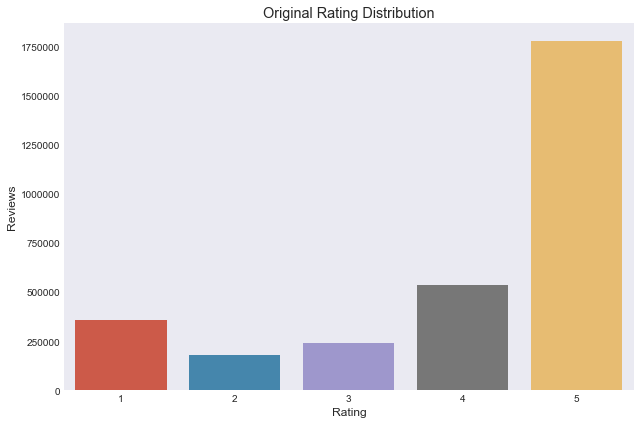

In [36]:
#
plt.figure(figsize=((9, 6)))
hist_ax = sns.countplot(x='star_rating', data=df)
hist_ax.set(xlabel='Rating', ylabel='Reviews')
hist_ax.set(title='Original Rating Distribution')

plt.tight_layout()